In [1]:

import numpy as np 
import pandas as pd 
import os
from typing import Tuple, Union
import matplotlib.pyplot as plt
import torch
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
import matplotlib.pyplot as plt

In [3]:
import torch.nn as nn
torch.manual_seed(16)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
class CapchaDataset(Dataset):
    """
    Датасет генерирует капчу длины seq_len из набора данных EMNIST
    """

    def __init__(
            self,
            seq_len: Union[int, Tuple[int, int]],
            img_h: int = 32,
            img_w: int = 32,
            split: str = "digits",
            samples: int = None,
    ):
        self.emnist_dataset = datasets.EMNIST(
            "./EMNIST", split=split, train=True, download=True
        )
        self.seq_len = seq_len
        self.blank_label = 0
        self.img_h = img_h
        self.img_w = img_w
        self.samples = samples
        self.num_classes = len(self.emnist_dataset.classes) + 1
        if isinstance(seq_len, int):
            self._min_seq_len = seq_len
            self._max_seq_len = seq_len
        elif (
                isinstance(seq_len, Tuple)
                and len(seq_len) == 2
                and isinstance(seq_len[0], int)
        ):
            self._min_seq_len = seq_len[0]
            self._max_seq_len = seq_len[1]

    def __len__(self):
        """
        Можно нагенерировать N различных капчей, где N - число сочетаний с повторениями.
        Если задано samples - вернуть его
        """
        if self.samples is not None:
            return self.samples
        return len(self.emnist_dataset.classes) ** self._max_seq_len

    def __preprocess(self, random_images: torch.Tensor) -> np.ndarray:
        transformed_images = []
        for img in random_images:
            img = transforms.ToPILImage()(img)
            img = TF.rotate(img, -90, fill=[0.0])
            img = TF.hflip(img)
            img = TF.resize(img, size=(self.img_h, self.img_w))
            img = transforms.ToTensor()(img).numpy()
            transformed_images.append(img)
        images = np.array(transformed_images)
        images = np.hstack(
            images.reshape((len(transformed_images), self.img_h, self.img_w))
        )
        full_img = np.zeros(shape=(self.img_h, self.img_w *  self._max_seq_len)).astype(
            np.float32
        )
        full_img[:, 0: images.shape[1]] = images
        return full_img

    def __getitem__(self, idx):
        # Get random seq_len
        random_seq_len = np.random.randint(self._min_seq_len, self._max_seq_len + 1)
        # Get random ind
        random_indices = np.random.randint(
            len(self.emnist_dataset.data), size=(random_seq_len,)
        )
        random_images = self.emnist_dataset.data[random_indices]
        random_digits_labels = self.emnist_dataset.targets[random_indices] + 1
        labels = torch.zeros((1, self._max_seq_len))
        labels = torch.fill(labels, self.blank_label)
        labels[0, 0: len(random_digits_labels)] = random_digits_labels
        x = self.__preprocess(random_images)
        y = labels.numpy().reshape(self._max_seq_len)
        return x, y


In [5]:
train_ds = CapchaDataset((3, 5))
val_ds = CapchaDataset((3, 5))
train_data_loader = torch.utils.data.DataLoader(train_ds, batch_size=32)
val_data_loader = torch.utils.data.DataLoader(val_ds, batch_size=32)


100%|██████████| 561753746/561753746 [00:03<00:00, 177461438.10it/s]


Extracting ./EMNIST/EMNIST/raw/gzip.zip to ./EMNIST/EMNIST/raw


In [6]:
batch, labels = next(iter(val_data_loader))
img = batch[0].cpu().detach().numpy()

In [7]:
labels[0]

tensor([ 6., 10.,  1.,  2.,  8.])

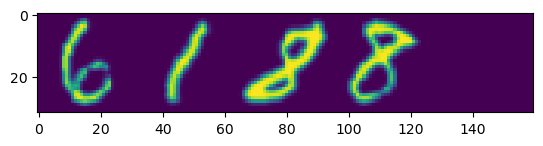

In [8]:
img = batch[31].cpu().detach().numpy()
plt.imshow(img)

In [9]:
labels[31]

tensor([7., 2., 9., 9., 0.])

In [10]:
train_ds.num_classes

11

In [11]:
class DeepBiLSTM(nn.Module):

    def __init__(self, inF, hidden, out):
        super(DeepBiLSTM, self).__init__()
        self.rnn = nn.LSTM(inF, hidden, bidirectional=True)
        self.embedding = nn.Linear(hidden * 2, out)
        
    def forward(self, x):
        self.rnn.flatten_parameters()
        x, _ = self.rnn(x)
        l, b, h = x.size()
        x = x.view(l * b, h)
        x = self.embedding(x)
        x = x.view(l, b, -1)
        return x

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size = 3, stride=1, padding=1)
        self.pooling1 = nn.MaxPool2d((2, 2), stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size = 3, stride=1, padding=1)
        self.pooling2 = nn.MaxPool2d((2, 2), stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size = 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size = 3, stride=1, padding=1)
        self.pooling3 = nn.MaxPool2d((1, 2), stride=2)
        self.conv5 = nn.Conv2d(256, 512, kernel_size = 3, stride=1, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size = 3, stride=1, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(512)
        self.pooling4 = nn.MaxPool2d((1, 2), stride=2)
        self.conv7 = nn.Conv2d(512, 512, kernel_size = 2, stride=1, padding=0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pooling1(x)
        x = self.conv2(x)
        x = self.pooling2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pooling3(x)
        x = self.conv5(x)
        x = self.batchnorm1(x)
        x = self.conv6(x)
        x = self.batchnorm2(x)
        x = self.pooling4(x)
        x = self.conv7(x)    
        return x

class CRNN(nn.Module):
    def __init__(self):
        super(CRNN, self).__init__()
        self.cnn = CNN()
        self.bilstm1 = DeepBiLSTM(512,256,256)
        self.bilstm2 = DeepBiLSTM(256,256,256)
        self.mapping = nn.Linear(256, 11)
        
    def forward(self, x):
        x = x.permute(1,0,2,3)
        x = self.cnn(x)
        x = x.squeeze(2)
        x = x.permute(2, 0, 1) 
        x = self.bilstm1(x)
        x = self.bilstm2(x)
        x = self.mapping(x)
        x = nn.functional.log_softmax(x, 2)
        return x
    

In [12]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
    elif isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [13]:

# torch.cuda.empty_cache()
model = CRNN()
model.apply(init_weights)
device = "cuda" if torch.cuda.is_available() else "cpu"
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0000001)
criterion = nn.CTCLoss(blank = 0, zero_infinity = True).to(device)

/tmp/ipykernel_23/3080275421.py:6: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)
/tmp/ipykernel_23/3080275421.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


In [14]:
epoch = 30
losses = []
model.to(device)
for x in range(epoch):
    model.train()
    epoch_losses_train = []
    print(f"Epoch {x}")
    for i, data in enumerate(tqdm(train_data_loader)):
        optimizer.zero_grad()
        batch, labels = data
        output = model(batch[None,:,:,:].to(device))
        input_length = torch.full(size = (output.size(1),), 
                                  fill_value = output.size(0),
                                 dtype = torch.int32)
        targets_length = torch.full(size = (labels.size(0),), 
                                  fill_value = labels.size(1),
                                 dtype = torch.int32)
        loss =  criterion( output, labels.to(device), input_length, targets_length)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        epoch_losses_train.append(loss.item())
    print("Train loss:", np.mean(epoch_losses_train))
    epoch_losses_val = []
    for i, data in enumerate(tqdm(val_data_loader)):
        model.eval()
        batch, labels = data
        output = model(batch[None,:,:,:].to(device))
        input_length = torch.full(size = (output.size(1),), 
                                  fill_value = output.size(0),
                                 dtype = torch.int32)
        targets_length = torch.full(size = (labels.size(0),), 
                                  fill_value = labels.size(1),
                                 dtype = torch.int32)

        loss =  criterion( output, labels.to(device), input_length, targets_length)
        epoch_losses_val.append(loss.item())
    print("Validation loss:", np.mean(epoch_losses_val))
    



Epoch 0


100%|██████████| 3125/3125 [03:06<00:00, 16.76it/s]


Train loss: 2.2771706467056276


100%|██████████| 3125/3125 [02:16<00:00, 22.97it/s]


Validation loss: 1.8760352897262573
Epoch 1


100%|██████████| 3125/3125 [03:01<00:00, 17.25it/s]


Train loss: 1.752054016532898


100%|██████████| 3125/3125 [02:16<00:00, 22.94it/s]


Validation loss: 1.641789468574524
Epoch 2


100%|██████████| 3125/3125 [03:00<00:00, 17.34it/s]


Train loss: 1.5510316222000122


100%|██████████| 3125/3125 [02:13<00:00, 23.37it/s]


Validation loss: 1.457533613319397
Epoch 3


100%|██████████| 3125/3125 [02:59<00:00, 17.45it/s]


Train loss: 1.3772455500030518


100%|██████████| 3125/3125 [02:14<00:00, 23.30it/s]


Validation loss: 1.2990935476112366
Epoch 4


100%|██████████| 3125/3125 [02:59<00:00, 17.43it/s]


Train loss: 1.2301850496101379


100%|██████████| 3125/3125 [02:14<00:00, 23.23it/s]


Validation loss: 1.1586841927528382
Epoch 5


100%|██████████| 3125/3125 [02:59<00:00, 17.40it/s]


Train loss: 1.0941382088279723


100%|██████████| 3125/3125 [02:15<00:00, 23.09it/s]


Validation loss: 1.0262515325927735
Epoch 6


100%|██████████| 3125/3125 [03:01<00:00, 17.25it/s]


Train loss: 0.9638349032592773


100%|██████████| 3125/3125 [02:15<00:00, 23.04it/s]


Validation loss: 0.9009250296783448
Epoch 7


100%|██████████| 3125/3125 [03:00<00:00, 17.30it/s]


Train loss: 0.8432864056587219


100%|██████████| 3125/3125 [02:15<00:00, 23.04it/s]


Validation loss: 0.7843560843849182
Epoch 8


100%|██████████| 3125/3125 [03:01<00:00, 17.21it/s]


Train loss: 0.7352087925815582


100%|██████████| 3125/3125 [02:16<00:00, 22.85it/s]


Validation loss: 0.6799942076587677
Epoch 9


100%|██████████| 3125/3125 [03:02<00:00, 17.15it/s]


Train loss: 0.6305784382629395


100%|██████████| 3125/3125 [02:17<00:00, 22.76it/s]


Validation loss: 0.5805947115230561
Epoch 10


100%|██████████| 3125/3125 [03:02<00:00, 17.10it/s]


Train loss: 0.5428692074918747


100%|██████████| 3125/3125 [02:17<00:00, 22.67it/s]


Validation loss: 0.49345558745384216
Epoch 11


100%|██████████| 3125/3125 [03:02<00:00, 17.10it/s]


Train loss: 0.46148159010887146


100%|██████████| 3125/3125 [02:17<00:00, 22.72it/s]


Validation loss: 0.42152507567882536
Epoch 12


100%|██████████| 3125/3125 [03:04<00:00, 16.95it/s]


Train loss: 0.39149486235141756


100%|██████████| 3125/3125 [02:18<00:00, 22.56it/s]


Validation loss: 0.35947448662281034
Epoch 13


100%|██████████| 3125/3125 [03:03<00:00, 17.00it/s]


Train loss: 0.330584567399025


100%|██████████| 3125/3125 [02:19<00:00, 22.35it/s]


Validation loss: 0.3038342806959152
Epoch 14


100%|██████████| 3125/3125 [03:05<00:00, 16.88it/s]


Train loss: 0.2795568359339237


100%|██████████| 3125/3125 [02:19<00:00, 22.41it/s]


Validation loss: 0.2567271571457386
Epoch 15


100%|██████████| 3125/3125 [03:04<00:00, 16.95it/s]


Train loss: 0.23670330529212952


100%|██████████| 3125/3125 [02:19<00:00, 22.48it/s]


Validation loss: 0.20844243275165558
Epoch 16


100%|██████████| 3125/3125 [03:04<00:00, 16.91it/s]


Train loss: 0.18779956546306611


100%|██████████| 3125/3125 [02:22<00:00, 21.91it/s]


Validation loss: 0.15923738707959653
Epoch 17


100%|██████████| 3125/3125 [03:07<00:00, 16.70it/s]


Train loss: 0.12314913975372911


100%|██████████| 3125/3125 [02:20<00:00, 22.18it/s]


Validation loss: 0.08054730101764201
Epoch 18


100%|██████████| 3125/3125 [03:05<00:00, 16.85it/s]


Train loss: 0.045323929728269576


100%|██████████| 3125/3125 [02:20<00:00, 22.29it/s]


Validation loss: 0.014307005471214652
Epoch 19


100%|██████████| 3125/3125 [03:06<00:00, 16.79it/s]


Train loss: -0.008681970363035798


100%|██████████| 3125/3125 [02:20<00:00, 22.17it/s]


Validation loss: -0.02802222048744559
Epoch 20


100%|██████████| 3125/3125 [03:06<00:00, 16.78it/s]


Train loss: -0.0426823411886394


100%|██████████| 3125/3125 [02:20<00:00, 22.17it/s]


Validation loss: -0.05440173889428377
Epoch 21


100%|██████████| 3125/3125 [03:06<00:00, 16.76it/s]


Train loss: -0.06500224164113402


100%|██████████| 3125/3125 [02:21<00:00, 22.15it/s]


Validation loss: -0.07229487318262458
Epoch 22


100%|██████████| 3125/3125 [03:07<00:00, 16.67it/s]


Train loss: -0.07883475312039256


100%|██████████| 3125/3125 [02:20<00:00, 22.20it/s]


Validation loss: -0.08627088073477149
Epoch 23


100%|██████████| 3125/3125 [03:04<00:00, 16.97it/s]


Train loss: -0.0902663797366619


100%|██████████| 3125/3125 [02:17<00:00, 22.66it/s]


Validation loss: -0.09477252719283104
Epoch 24


100%|██████████| 3125/3125 [03:05<00:00, 16.84it/s]


Train loss: -0.09947702761054039


100%|██████████| 3125/3125 [02:17<00:00, 22.65it/s]


Validation loss: -0.10342385413631797
Epoch 25


100%|██████████| 3125/3125 [03:02<00:00, 17.14it/s]


Train loss: -0.10553321983397007


100%|██████████| 3125/3125 [02:19<00:00, 22.39it/s]


Validation loss: -0.1084205868268013
Epoch 26


100%|██████████| 3125/3125 [03:03<00:00, 17.02it/s]


Train loss: -0.11019260937929154


100%|██████████| 3125/3125 [02:18<00:00, 22.53it/s]


Validation loss: -0.11334830039650202
Epoch 27


100%|██████████| 3125/3125 [03:04<00:00, 16.97it/s]


Train loss: -0.11432886078760028


100%|██████████| 3125/3125 [02:18<00:00, 22.54it/s]


Validation loss: -0.11743929976537823
Epoch 28


100%|██████████| 3125/3125 [03:05<00:00, 16.84it/s]


Train loss: -0.11800120702564716


100%|██████████| 3125/3125 [02:18<00:00, 22.52it/s]


Validation loss: -0.12007160170465708
Epoch 29


100%|██████████| 3125/3125 [03:03<00:00, 17.04it/s]


Train loss: -0.12120256345421075


100%|██████████| 3125/3125 [02:19<00:00, 22.40it/s]

Validation loss: -0.12377079118013382


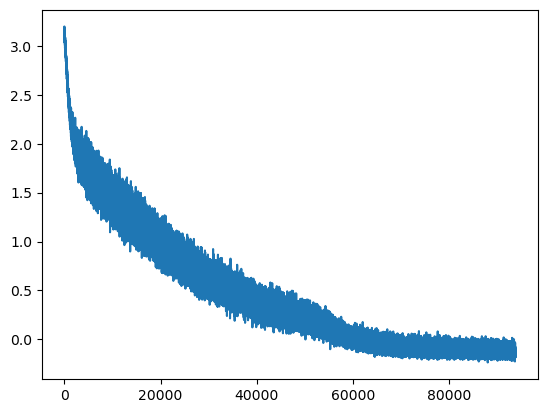

In [15]:
plt.plot(losses)

In [16]:
len(input_length)

32

In [17]:
output.size(1)

32

## Test model

In [18]:
batch, labels = next(iter(val_data_loader))

/tmp/ipykernel_23/1600311747.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


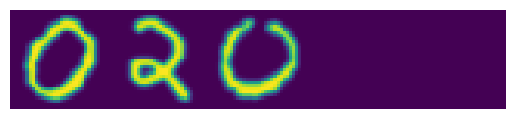

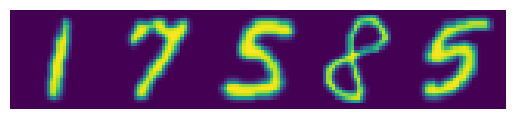

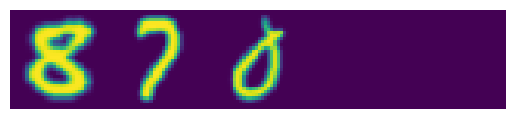

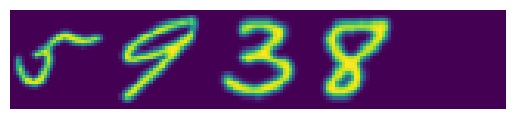

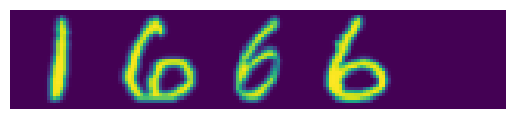

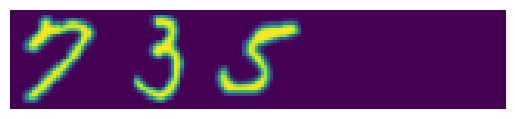

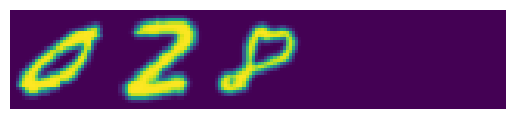

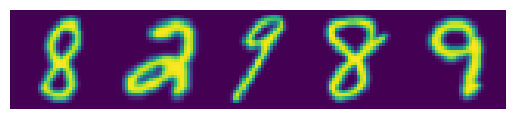

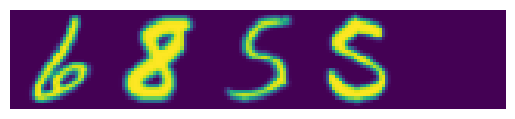

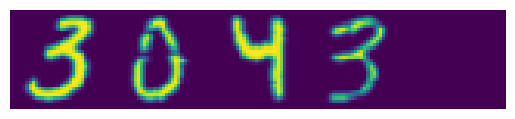

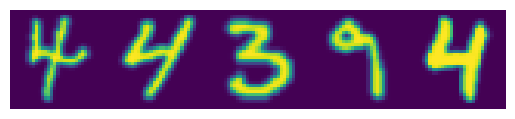

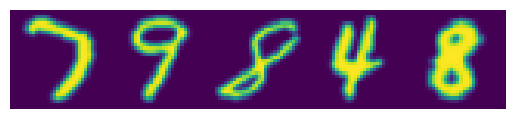

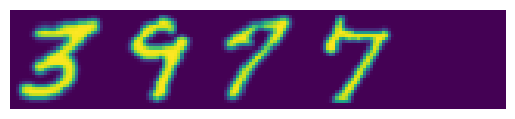

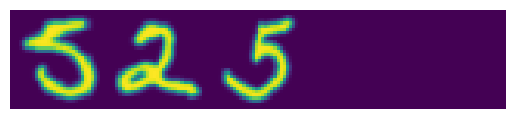

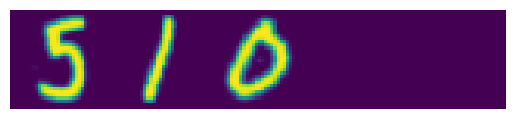

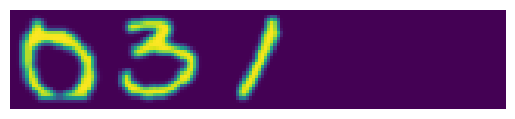

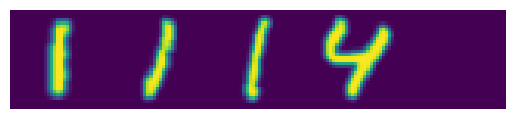

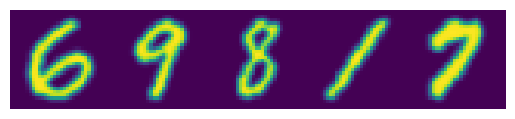

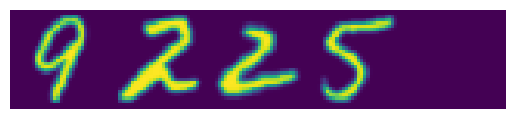

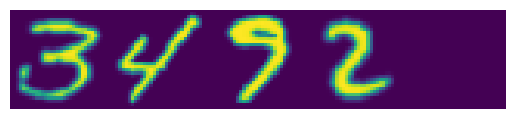

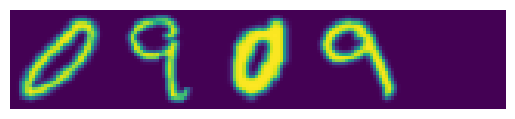

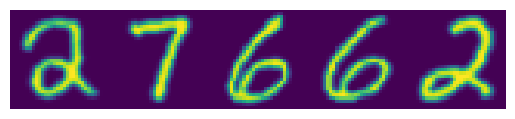

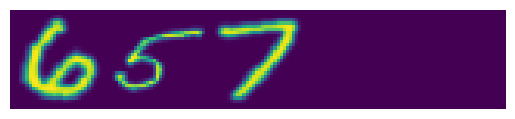

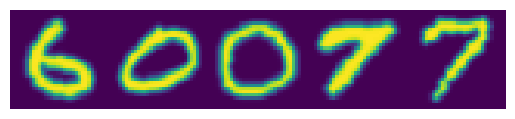

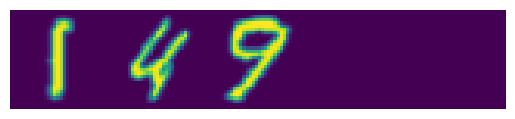

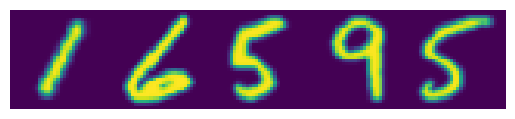

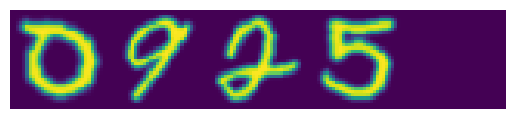

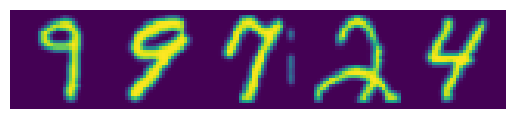

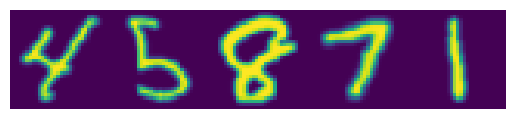

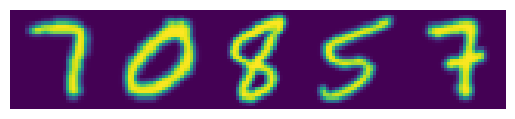

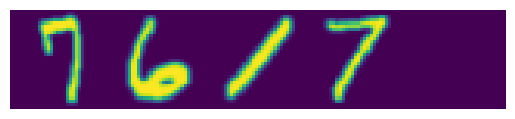

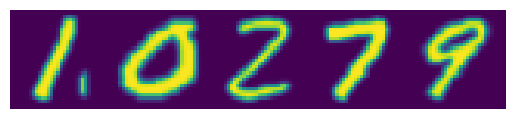

In [19]:
for x in batch:
    plt.figure()
    plt.axis('off')
    plt.imshow(x)

In [20]:
model.eval()
output = model(batch[None,:,:,:].to("cuda"))

In [21]:
from sklearn.preprocessing import LabelEncoder

In [22]:
encoder= LabelEncoder()
encoder.fit([0,1,2,3,4,5,6,7,8,9,10])

LabelEncoder()

In [23]:
def remove_duplicates(x):
    if len(x) < 2:
        return x
    fin = ""
    for j in x:
        if fin == "":
            fin = j
        else:
            if j == fin[-1]:
                continue
            else:
                fin = fin + j
    return fin


def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j, :]:
            k = k - 1
            if k == -1:
                temp.append("§")
            else:
                p = encoder.inverse_transform([k])[0]
                temp.append(str(p))
        tp = "".join(temp).replace("§", "")
        cap_preds.append(remove_duplicates(tp))
    return cap_preds
    

In [24]:
output.size()

torch.Size([9, 32, 11])

In [25]:
decode_predictions(output, encoder)

['020',
 '17585',
 '870',
 '5938',
 '16',
 '735',
 '02',
 '82989',
 '685',
 '3043',
 '4374',
 '79848',
 '397',
 '525',
 '510',
 '031',
 '14',
 '69817',
 '925',
 '3472',
 '0909',
 '2762',
 '657',
 '607',
 '149',
 '16595',
 '0925',
 '9724',
 '45871',
 '70857',
 '7617',
 '10279']

In [26]:
labels

tensor([[ 1.,  3.,  1.,  0.,  0.],
        [ 2.,  8.,  6.,  9.,  6.],
        [ 9.,  8.,  1.,  0.,  0.],
        [ 6., 10.,  4.,  9.,  0.],
        [ 2.,  7.,  7.,  7.,  0.],
        [ 8.,  4.,  6.,  0.,  0.],
        [ 1.,  3.,  9.,  0.,  0.],
        [ 9.,  3., 10.,  9., 10.],
        [ 7.,  9.,  6.,  6.,  0.],
        [ 4.,  1.,  5.,  4.,  0.],
        [ 5.,  5.,  4., 10.,  5.],
        [ 8., 10.,  9.,  5.,  9.],
        [ 4., 10.,  8.,  8.,  0.],
        [ 6.,  3.,  6.,  0.,  0.],
        [ 6.,  2.,  1.,  0.,  0.],
        [ 1.,  4.,  2.,  0.,  0.],
        [ 2.,  2.,  2.,  5.,  0.],
        [ 7., 10.,  9.,  2.,  8.],
        [10.,  3.,  3.,  6.,  0.],
        [ 4.,  5., 10.,  3.,  0.],
        [ 1., 10.,  1., 10.,  0.],
        [ 3.,  8.,  7.,  7.,  3.],
        [ 7.,  6.,  8.,  0.,  0.],
        [ 7.,  1.,  1.,  8.,  8.],
        [ 2.,  5., 10.,  0.,  0.],
        [ 2.,  7.,  6., 10.,  6.],
        [ 1., 10.,  3.,  6.,  0.],
        [10., 10.,  8.,  3.,  5.],
        [ 5.,  6.,  

In [27]:
torch.save(model.state_dict(), './crnn_model.pth')